In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import ColumnSelector

from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.backend import clear_session
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), '../'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

from server.ml_models import PlayerRidge
from server.ml_models.player_ridge import PlayerRidgeData
from server.data_processors.feature_functions import (
    add_last_year_brownlow_votes,
    add_rolling_player_stats,
    add_cum_matches_played
)
from server.data_processors import (
    FeatureBuilder,
    PlayerDataStacker,
    OppoFeatureBuilder
)
from server.data_processors import FitzroyDataReader
from src.model.metrics import regression_accuracy, measure_estimators

FEATURE_FUNCS = [
    add_last_year_brownlow_votes,
    add_rolling_player_stats,
    add_cum_matches_played
]
DATA_TRANSFORMERS = [
    PlayerDataStacker().transform,
    FeatureBuilder(
        feature_funcs=FEATURE_FUNCS,
        index_cols=['team', 'year', 'round_number', 'player_id']
    ).transform
]
fitzroy = FitzroyDataReader()
DATA_READERS = [
    fitzroy.get_afltables_stats,
    fitzroy.match_results
]
START_DATE = '1965-01-01'

np.random.seed(42)

def graph_model_history(history):
    acc = history.history['tip_accuracy']
    val_acc = history.history['val_tip_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
def graph_yearly_model_performance(year_data_frame, error=True):
    if error:
        # MAE scores
        plt.figure(figsize=(15, 9))
        sns.barplot(x='year', y='error', hue='model', data=year_data_frame)
        # Not starting axis at 0 to make small relative differences clearer
        plt.ylim(bottom=20)
        plt.title('Model error per season\n', fontsize=18)
        plt.ylabel('MAE', fontsize=14)
        plt.xlabel('', fontsize=14)
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        plt.legend(fontsize=14)

        plt.show()

    # Accuracy scores
    plt.figure(figsize=(15, 8))
    sns.barplot(x='year', y='accuracy', hue='model', data=year_data_frame)
    # Not starting axis at 0 to make small relative differences clearer
    plt.ylim(bottom=0.55)
    plt.title('Model accuracy per season\n', fontsize=18)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12, rotation=90)
    plt.legend(fontsize=14)

    plt.show()

In [2]:
# Get player data, stack by team-match, and add player-relevant features

player_data = PlayerRidgeData(data_readers=DATA_READERS,
                            data_transformers=DATA_TRANSFORMERS,
                            start_date=START_DATE,
                            train_years=(None, None),
                            test_years=(None, None))
player_data.data

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/app/server/data_processors/feature_functions.py:524: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(['player_id', 'year'], group_keys=True)
/app/server/data_processors/feature_functions.py:524: FutureWarning: 'year' is both an index level and a column label.
Defau

at_home  \
team          year round_number player_id            
Adelaide      1991 1            1                1   
                   2            1                1   
                   3            1                0   
                   4            1                0   
                   5            1                0   
                   6            1                1   
                   7            1                0   
                   9            1                0   
                   10           1                1   
                   11           1                0   
                   12           1                1   
                   13           1                0   
                   14           1                1   
                   15           1                0   
                   16           1                0   
                   17           1                0   
                   18           1                1   
                   19           1                1   
                   20           1                1   
                   21           1                0   
                   22           1                1   
                   24           1                1   
              1992 1            1                1   
                   3            1                0   
                   4            1                0   
                   5            1                1   
                   6            1                1   
                   7            1                0   
                   8            1                0   
                   9            1                1   
...                                            ...   
Brisbane      2016 21           12472            1   
Adelaide      2016 20           12473            1   
                   21           12473            0   
Hawthorn      2016 20           12474            0   
Melbourne     2016 20           12475            1   
                   22           12475            0   
                   23           12475            0   
Carlton       2016 21           12476            0   
                   22           12476            1   
                   23           12476            0   
Hawthorn      2016 21           12477            1   
                   22           12477            0   
                   23           12477            1   
                   24           12477            0   
Port Adelaide 2016 21           12478            1   
                   22           12478            1   
                   23           12478            0   
Essendon      2016 21           12479            1   
                   22           12479            1   
                   23           12479            1   
Richmond      2016 22           12480            1   
                   23           12480            0   
Gold Coast    2016 22           12481            0   
                   23           12481            1   
Brisbane      2016 22           12482            1   
                   23           12482            0   
Port Adelaide 2016 23           12483            0   
                                12484            0   
Richmond      2016 23           12485            0   
St Kilda      2016 23           12486            1   

                                           rolling_prev_match_behinds  \
team          year round_number player_id                               
Adelaide      1991 1            1                            0.000000   
                   2            1                            0.000000   
                   3            1                            0.000000   
                   4            1                            0.000000   
                   5            1                            0.000000   
                   6            1                            0.000000   
                   7            1                       

In [3]:
# Get aggregated player data to add oppo stats columns to un-aggregated player data

agg_data = PlayerRidgeData(start_date=START_DATE,
                         train_years=(None, None),
                         test_years=(None, None))
agg_data.data

/app/server/data_processors/player_data_aggregator.py:65: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(self.index_cols + ['oppo_team'])
/app/server/data_processors/player_data_aggregator.py:65: FutureWarning: 'year' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(self.index_cols + ['oppo_team'])
/app/server/data_processors/player_data_aggregator.py:65: FutureWarning: 'round_number' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(self.index_cols + ['oppo_team'])


team  year  round_number  \
team             year round_number                                         
Adelaide         1991 1                     Adelaide  1991             1   
                      2                     Adelaide  1991             2   
                      3                     Adelaide  1991             3   
                      4                     Adelaide  1991             4   
                      5                     Adelaide  1991             5   
                      6                     Adelaide  1991             6   
                      7                     Adelaide  1991             7   
                      9                     Adelaide  1991             9   
                      10                    Adelaide  1991            10   
                      11                    Adelaide  1991            11   
                      12                    Adelaide  1991            12   
                      13                    Adelaide  1991            13   
                      14                    Adelaide  1991            14   
                      15                    Adelaide  1991            15   
                      16                    Adelaide  1991            16   
                      17                    Adelaide  1991            17   
                      18                    Adelaide  1991            18   
                      19                    Adelaide  1991            19   
                      20                    Adelaide  1991            20   
                      21                    Adelaide  1991            21   
                      22                    Adelaide  1991            22   
                      24                    Adelaide  1991            24   
                 1992 1                     Adelaide  1992             1   
                      3                     Adelaide  1992             3   
                      4                     Adelaide  1992             4   
                      5                     Adelaide  1992             5   
                      6                     Adelaide  1992             6   
                      7                     Adelaide  1992             7   
                      8                     Adelaide  1992             8   
                      9                     Adelaide  1992             9   
...                                              ...   ...           ...   
Western Bulldogs 2015 21            Western Bulldogs  2015            21   
                      22            Western Bulldogs  2015            22   
                      23            Western Bulldogs  2015            23   
                      24            Western Bulldogs  2015            24   
                 2016 1             Western Bulldogs  2016             1   
                      2             Western Bulldogs  2016             2   
                      3             Western Bulldogs  2016             3   
                      4             Western Bulldogs  2016             4   
                      5             Western Bulldogs  2016             5   
                      6             Western Bulldogs  2016             6   
                      7             Western Bulldogs  2016             7   
                      8             Western Bulldogs  2016             8   
                      9             Western Bulldogs  2016             9   
                      10            Western Bulldogs  2016            10   
                      11            Western Bulldogs  2016            11   
                      12            Western Bulldogs  2016            12   
                      13            Western Bulldogs  2016            13   
                      15            Western Bulldogs  2016            15   
                      16            Western Bulldogs  2016            16   
                      17            Western Bulldogs  2016            17   
                    

In [4]:
# Prepare data for putting into a model, sorting columns to get categories first

from functools import partial

SORT_COLS = ['team', 'year', 'round_number', 'player_id']
CATEGORY_COLS = ['team', 'oppo_team', 'player_id']
MATCH_COLS = ['team', 'oppo_team', 'at_home', 'round_number', 'score', 'oppo_score', 'year']

def col_value(tm_group, col):
    if col in MATCH_COLS:
        return tm_group[col][-1]
    return 0

# Merge player data with team stats data
data = (player_data
        .data
        .join(agg_data.data.filter(regex='^oppo_last|^oppo_rolling'),
              on=('team', 'year', 'round_number'),
              how='left')
        .sort_index())

total_cols = CATEGORY_COLS + list(data.drop(CATEGORY_COLS, axis=1).columns)
    
max_player_id = data['player_id'].max()
team_match_groups = data.groupby(['team', 'year', 'round_number'])
max_n_players = team_match_groups.count().max().max()

# Pad team-matches with blank players for a consistent number when reshaping data
padding = []

for _, tm_group in team_match_groups:
    diff = max_n_players - len(tm_group)

    if diff > 0:
        group_col_value = partial(col_value, tm_group)
        index = [tuple((*tm_group.index.droplevel(3).values[-1], max_player_id + 1 + n)) for n in range(diff)]
        df_dict = {col: group_col_value(col) for col in data.columns}
        blank_row = (pd
                     .DataFrame(df_dict, index=index)
                     .assign(player_id=list(range(max_player_id + 1, max_player_id + 1 + diff))))

        padding.append(blank_row)
        
padded_df = pd.concat([data] + padding, sort=True)[total_cols].sort_index()
padded_df

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'year' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'round_number' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/usr/local/lib/python3.6/site-packages/ipykernel_launch

team oppo_team  \
team             year round_number player_id                               
Adelaide         1991 1            1                  Adelaide  Hawthorn   
                                   3                  Adelaide  Hawthorn   
                                   5                  Adelaide  Hawthorn   
                                   8                  Adelaide  Hawthorn   
                                   9                  Adelaide  Hawthorn   
                                   17                 Adelaide  Hawthorn   
                                   18                 Adelaide  Hawthorn   
                                   26                 Adelaide  Hawthorn   
                                   1289               Adelaide  Hawthorn   
                                   1316               Adelaide  Hawthorn   
                                   1921               Adelaide  Hawthorn   
                                   3785               Adelaide  Hawthorn   
                                   3990               Adelaide  Hawthorn   
                                   11504              Adelaide  Hawthorn   
                                   11505              Adelaide  Hawthorn   
                                   11507              Adelaide  Hawthorn   
                                   11509              Adelaide  Hawthorn   
                                   11510              Adelaide  Hawthorn   
                                   11512              Adelaide  Hawthorn   
                                   11513              Adelaide  Hawthorn   
                                   12487              Adelaide  Hawthorn   
                                   12488              Adelaide  Hawthorn   
                                   12489              Adelaide  Hawthorn   
                                   12490              Adelaide  Hawthorn   
                                   12491              Adelaide  Hawthorn   
                                   12492              Adelaide  Hawthorn   
                      2            1                  Adelaide   Carlton   
                                   5                  Adelaide   Carlton   
                                   8                  Adelaide   Carlton   
                                   9                  Adelaide   Carlton   
...                                                        ...       ...   
Western Bulldogs 2016 26           12487      Western Bulldogs       GWS   
                                   12488      Western Bulldogs       GWS   
                                   12489      Western Bulldogs       GWS   
                                   12490      Western Bulldogs       GWS   
                      27           1450       Western Bulldogs    Sydney   
                                   4084       Western Bulldogs    Sydney   
                                   11731      Western Bulldogs    Sydney   
                                   11788      Western Bulldogs    Sydney   
                                   11833      Western Bulldogs    Sydney   
                                   11898      Western Bulldogs    Sydney   
                                   11974      Western Bulldogs    Sydney   
                                   12042      Western Bulldogs    Sydney   
                                   12043      Western Bulldogs    Sydney   
                                   12122      Western Bulldogs    Sydney   
                                   12126      Western Bulldogs    Sydney   
                                   12166      Western Bulldogs    Sydney   
                                   12167      Western Bulldogs    Sydney   
                                   12203      Western Bulldogs    Sydney   
                                   12228      Western Bulldogs    Sydney   
                                   12269      Western Bulldogs    Sydney   
                              

In [5]:
# Create pipeline & reshape data inputs

from sklearn.base import BaseEstimator, TransformerMixin

class DimensionReshaper(BaseEstimator, TransformerMixin):
    def __init__(self, shape=None):
        self.shape = shape
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.reshape(self.shape)
    
class InputLister(BaseEstimator, TransformerMixin):
    def __init__(self, n_inputs=1):
        self.n_inputs = n_inputs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [X[:, :, n] if n < self.n_inputs - 1 else X[:, :, n:] for n in range(self.n_inputs)]
    
import tensorflow.keras.backend as K

def tip_accuracy(y, y_pred):
    correct_preds = ((y >= 0) & (y_pred >= 0)) | ((y <= 0) & (y_pred <= 0))
    return K.mean(correct_preds)
    
n_teams = len(data['team'].drop_duplicates())
min_n_players = team_match_groups.count().min().min()
max_min_diff = max_n_players - min_n_players

features = padded_df.drop(['score', 'oppo_score', 'player_name'], axis=1)
labels = padded_df['score'] - padded_df['oppo_score']

feat_train = features[features['year'] < 2016]
feat_test = features[features['year'] == 2016]
lab_train = labels[feat_train.index]
lab_test = labels[feat_test.index]

n_players_per_team_match = int(padded_df.groupby(['team', 'year', 'round_number'])['team'].count().mean())
n_features = len(features.columns)
n_labels = 1

cat_pipe = make_pipeline(ColumnSelector(cols=[0, 1, 2]), OrdinalEncoder())
num_pipe = make_pipeline(ColumnSelector(cols=list(range(3, n_features))), StandardScaler())

label_reshaper = DimensionReshaper((-1, n_players_per_team_match, n_labels))

X_train = feat_train.values
X_test = feat_test.values
y_train = label_reshaper.transform(lab_train.values)[:, 0, :]
y_test = label_reshaper.transform(lab_test.values)[:, 0, :]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: 'year' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: 'round_number' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


## CNN without regularization

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 5s 360us/step - loss: 33.0489 - tip_accuracy: 0.6385 - val_loss: 31.5993 - val_tip_accuracy: 0.6474
Epoch 2/20
13158/13158 [==============================] - 3s 241us/step - loss: 30.6792 - tip_accuracy: 0.6847 - val_loss: 31.9063 - val_tip_accuracy: 0.6483
Epoch 3/20
13158/13158 [==============================] - 4s 338us/step - loss: 29.5921 - tip_accuracy: 0.7039 - val_loss: 31.9611 - val_tip_accuracy: 0.6407
Epoch 4/20
13158/13158 [==============================] - 4s 322us/step - loss: 28.8585 - tip_accuracy: 0.7123 - val_loss: 32.5667 - val_tip_accuracy: 0.6340
Epoch 5/20
13158/13158 [==============================] - 3s 240us/step - loss: 28.2470 - tip_accuracy: 0.7196 - val_loss: 31.4985 - val_tip_accuracy: 0.6568
Epoch 6/20
13158/13158 [==============================] - 3s 242us/step - loss: 27.7536 - tip_accuracy: 0.7301 - val_loss: 32.0791 - val_tip_accuracy: 0.6422
Epo

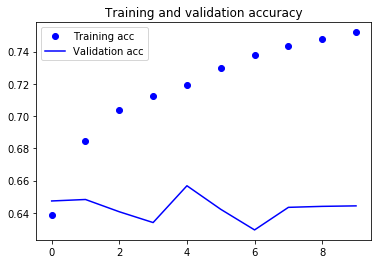

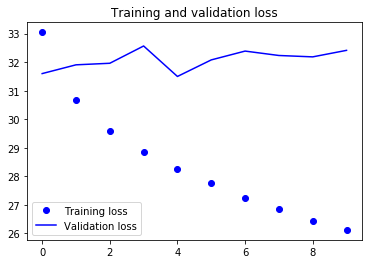

In [6]:
clear_session()

def create_cnn_model():
    cnn_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='team')
    cnn_oppo_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='oppo_team')
    cnn_player_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='player')
    cnn_stats_input = layers.Input(shape=(n_players_per_team_match, n_features - 3), dtype='float32', name='stats')

    cnn_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(cnn_team_input)
    cnn_oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(cnn_oppo_team_input)
    cnn_player_layer = layers.Embedding(max_player_id + max_min_diff + 1, 4, input_length=n_players_per_team_match)(cnn_player_input)

    cnn_concated_layers = layers.concatenate([cnn_team_layer, cnn_oppo_team_layer, cnn_player_layer, cnn_stats_input])

    cnn_conv_layer_1 = layers.Conv1D(32, 3, activation='relu')(cnn_concated_layers)
    cnn_pool_layer_1 = layers.MaxPooling1D(2)(cnn_conv_layer_1)
    cnn_conv_layer_2 = layers.Conv1D(32, 3, activation='relu')(cnn_pool_layer_1)
    cnn_pool_layer_2 = layers.GlobalMaxPooling1D()(cnn_conv_layer_2)
    cnn_output = layers.Dense(1)(cnn_pool_layer_2)

    cnn_model = models.Model(
        inputs=[
            cnn_team_input,
            cnn_oppo_team_input,
            cnn_player_input,
            cnn_stats_input
        ],
        outputs=cnn_output
    )
    cnn_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])

    return cnn_model


cnn_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    DimensionReshaper((-1, n_players_per_team_match, n_features)),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_cnn_model,
                   epochs=20,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)])
)

cnn_pipe.fit(X_train, y_train)

graph_model_history(cnn_pipe.steps[-1][1].model.history)

## CNN with dropout

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 4s 331us/step - loss: 33.7821 - tip_accuracy: 0.6086 - val_loss: 32.4577 - val_tip_accuracy: 0.6565
Epoch 2/20
13158/13158 [==============================] - 4s 272us/step - loss: 31.4436 - tip_accuracy: 0.6765 - val_loss: 32.6236 - val_tip_accuracy: 0.6562
Epoch 3/20
13158/13158 [==============================] - 3s 259us/step - loss: 30.3714 - tip_accuracy: 0.6969 - val_loss: 32.7455 - val_tip_accuracy: 0.6371
Epoch 4/20
13158/13158 [==============================] - 4s 292us/step - loss: 29.8905 - tip_accuracy: 0.7047 - val_loss: 32.6367 - val_tip_accuracy: 0.6429
Epoch 5/20
13158/13158 [==============================] - 3s 263us/step - loss: 29.4803 - tip_accuracy: 0.7093 - val_loss: 32.4924 - val_tip_accuracy: 0.6432
Epoch 6/20
13158/13158 [==============================] - 3s 251us/step - loss: 29.1236 - tip_accuracy: 0.7176 - val_loss: 32.9127 - val_tip_accuracy: 0.6261


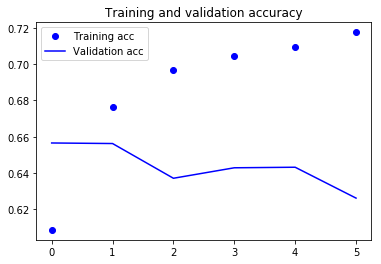

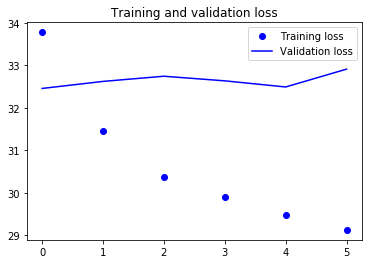

In [7]:
def create_do_model():
    do_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='team')
    do_oppo_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='oppo_team')
    do_player_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='player')
    do_stats_input = layers.Input(shape=(n_players_per_team_match, n_features - 3), dtype='float32', name='stats')

    do_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(do_team_input)
    do_oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(do_oppo_team_input)
    do_player_layer = layers.Embedding(max_player_id + max_min_diff + 1, 4, input_length=n_players_per_team_match)(do_player_input)

    do_concated_layers = layers.concatenate([do_team_layer, do_oppo_team_layer, do_player_layer, do_stats_input])

    do_conv_layer_1 = layers.Conv1D(32, 3, activation='relu')(do_concated_layers)
    do_dropout_layer_1 = layers.Dropout(rate=0.2)(do_conv_layer_1)

    do_pool_layer_1 = layers.MaxPooling1D(2)(do_dropout_layer_1)
    do_dropout_layer_2 = layers.Dropout(rate=0.2)(do_pool_layer_1)

    do_conv_layer_2 = layers.Conv1D(32, 3, activation='relu')(do_dropout_layer_2)
    do_dropout_layer_3 = layers.Dropout(rate=0.4)(do_conv_layer_2)

    do_pool_layer_2 = layers.GlobalMaxPooling1D()(do_dropout_layer_3)
    do_dropout_layer_4 = layers.Dropout(rate=0.4)(do_pool_layer_2)

    do_output = layers.Dense(1)(do_dropout_layer_4)

    do_model = models.Model(
        inputs=[
            do_team_input,
            do_oppo_team_input,
            do_player_input,
            do_stats_input
        ],
        outputs=do_output
    )
    do_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])
    return do_model


do_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    DimensionReshaper((-1, n_players_per_team_match, n_features)),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_do_model,
                   epochs=20,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)])
)

do_pipe.fit(X_train, y_train)

graph_model_history(do_pipe.steps[-1][1].model.history)

## CNN with l2 regularization

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 4s 293us/step - loss: 33.1189 - tip_accuracy: 0.6397 - val_loss: 31.8437 - val_tip_accuracy: 0.6517
Epoch 2/20
13158/13158 [==============================] - 3s 247us/step - loss: 30.7921 - tip_accuracy: 0.6863 - val_loss: 31.5071 - val_tip_accuracy: 0.6556
Epoch 3/20
13158/13158 [==============================] - 3s 247us/step - loss: 29.8005 - tip_accuracy: 0.7035 - val_loss: 31.7620 - val_tip_accuracy: 0.6529
Epoch 4/20
13158/13158 [==============================] - 3s 246us/step - loss: 29.0794 - tip_accuracy: 0.7136 - val_loss: 32.8161 - val_tip_accuracy: 0.6301
Epoch 5/20
13158/13158 [==============================] - 4s 320us/step - loss: 28.5428 - tip_accuracy: 0.7231 - val_loss: 32.3523 - val_tip_accuracy: 0.6383
Epoch 6/20
13158/13158 [==============================] - 3s 248us/step - loss: 28.0210 - tip_accuracy: 0.7285 - val_loss: 33.2077 - val_tip_accuracy: 0.6258
Epo

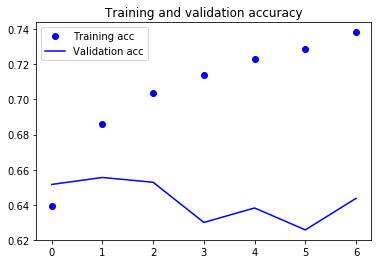

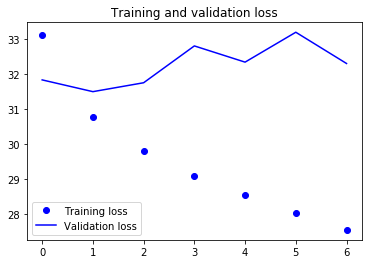

In [8]:
def create_l2_model():
    l2_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='team')
    l2_oppo_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='oppo_team')
    l2_player_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='player')
    l2_stats_input = layers.Input(shape=(n_players_per_team_match, n_features - 3), dtype='float32', name='stats')

    l2_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(l2_team_input)
    l2_oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(l2_oppo_team_input)
    l2_player_layer = layers.Embedding(max_player_id + max_min_diff + 1, 4, input_length=n_players_per_team_match)(l2_player_input)

    l2_concated_layers = layers.concatenate([l2_team_layer, l2_oppo_team_layer, l2_player_layer, l2_stats_input])

    l2_conv_layer_1 = layers.Conv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001))(l2_concated_layers)
    l2_pool_layer_1 = layers.MaxPooling1D(2)(l2_conv_layer_1)
    l2_conv_layer_2 = layers.Conv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.002))(l2_pool_layer_1)
    l2_pool_layer_2 = layers.GlobalMaxPooling1D()(l2_conv_layer_2)
    l2_output = layers.Dense(1, kernel_regularizer=regularizers.l2(0.004))(l2_pool_layer_2)

    l2_model = models.Model(
        inputs=[
            l2_team_input,
            l2_oppo_team_input,
            l2_player_input,
            l2_stats_input
        ],
        outputs=l2_output
    )
    l2_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])
    return l2_model


l2_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    DimensionReshaper((-1, n_players_per_team_match, n_features)),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_l2_model,
                   epochs=20,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)])
)

l2_pipe.fit(X_train, y_train)

graph_model_history(l2_pipe.steps[-1][1].model.history)

## CNN performance by year

In [9]:
ridge_data = PlayerRidgeData(train_years=(None, 2016), test_years=(None, None))
ridge_X, ridge_y = ridge_data.train_data()
ridge_estimator = PlayerRidge()

def yearly_performance_scores(estimators, features, labels):
    model_names = []
    errors = []
    accuracies = []
    years = []

    for year in range(2011, 2017):
        feat_train = features[features['year'] < year]
        feat_test = features[features['year'] == year]
        X_train = feat_train.values
        X_test = feat_test.values

        lab_train = labels.loc[feat_train.index]
        lab_test = labels.loc[feat_test.index]
        y_train = label_reshaper.transform(lab_train.values)[:, 0, :]
        y_test = label_reshaper.transform(lab_test.values)[:, 0, :]

        for estimator_name, estimator in estimators:
            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test).reshape((-1, 1))

            years.append(year)
            model_names.append(estimator_name)
            errors.append(mean_absolute_error(y_test, y_pred))
            accuracies.append(regression_accuracy(y_test, y_pred))

    year_scores = pd.DataFrame({'model': model_names,
                                'year': years,
                                'error': errors,
                                'accuracy': accuracies}).astype({'year': int})
    
    return year_scores

def yearly_ridge_performance_scores(estimators, features, labels):
    model_names = []
    errors = []
    accuracies = []
    years = []

    for year in range(2011, 2017):
        X_train = features[features['year'] < year]
        X_test = features[features['year'] == year]

        y_train = labels.loc[X_train.index]
        y_test = labels.loc[X_test.index]

        for estimator_name, estimator in estimators:
            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test)

            years.append(year)
            model_names.append(estimator_name)
            errors.append(mean_absolute_error(y_test, y_pred))
            accuracies.append(regression_accuracy(y_test, y_pred))

    year_scores = pd.DataFrame({'model': model_names,
                                    'year': years,
                                    'error': errors,
                                    'accuracy': accuracies}).astype({'year': int})
    
    return year_scores

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/app/server/data_processors/feature_functions.py:524: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(['player_id', 'year'], group_keys=True)
/app/server/data_processors/feature_functions.py:524: FutureWarning: 'year' is both an index level and a column label.
Defau

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 11521 samples, validate on 2881 samples
Epoch 1/20
11521/11521 [==============================] - 3s 248us/step - loss: 33.4076 - tip_accuracy: 0.6163 - val_loss: 31.6491 - val_tip_accuracy: 0.6456
Epoch 2/20
11521/11521 [==============================] - 2s 197us/step - loss: 30.8967 - tip_accuracy: 0.6818 - val_loss: 31.7867 - val_tip_accuracy: 0.6394
Epoch 3/20
11521/11521 [==============================] - 2s 215us/step - loss: 29.7692 - tip_accuracy: 0.6946 - val_loss: 31.9032 - val_tip_accuracy: 0.6369
Epoch 4/20
11521/11521 [==============================] - 2s 196us/step - loss: 29.0471 - tip_accuracy: 0.7056 - val_loss: 31.6018 - val_tip_accuracy: 0.6460
Epoch 5/20
11521/11521 [==============================] - 2s 198us/step - loss: 28.4400 - tip_accuracy: 0.7104 - val_loss: 32.6854 - val_tip_accuracy: 0.6171
Epoch 6/20
11521/11521 [==============================] - 2s 197us/step - loss: 27.9551 - tip_accuracy: 0.7249 - val_loss: 32.3109 - val_tip_accuracy: 0.6272
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 11521 samples, validate on 2881 samples
Epoch 1/20
11521/11521 [==============================] - 3s 279us/step - loss: 33.8738 - tip_accuracy: 0.5978 - val_loss: 32.7296 - val_tip_accuracy: 0.6491
Epoch 2/20
11521/11521 [==============================] - 3s 222us/step - loss: 31.7443 - tip_accuracy: 0.6682 - val_loss: 32.2223 - val_tip_accuracy: 0.6494
Epoch 3/20
11521/11521 [==============================] - 3s 232us/step - loss: 30.9161 - tip_accuracy: 0.6815 - val_loss: 32.0951 - val_tip_accuracy: 0.6487
Epoch 4/20
11521/11521 [==============================] - 3s 227us/step - loss: 30.1414 - tip_accuracy: 0.6923 - val_loss: 32.4511 - val_tip_accuracy: 0.6404
Epoch 5/20
11521/11521 [==============================] - 3s 229us/step - loss: 29.7281 - tip_accuracy: 0.6993 - val_loss: 32.2341 - val_tip_accuracy: 0.6435
Epoch 6/20
11521/11521 [==============================] - 3s 263us/step - loss: 29.3457 - tip_accuracy: 0.7087 - val_loss: 32.8271 - val_tip_accuracy: 0.6171
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 11521 samples, validate on 2881 samples
Epoch 1/20
11521/11521 [==============================] - 3s 268us/step - loss: 33.3054 - tip_accuracy: 0.6254 - val_loss: 32.6897 - val_tip_accuracy: 0.6189
Epoch 2/20
11521/11521 [==============================] - 2s 203us/step - loss: 31.0295 - tip_accuracy: 0.6790 - val_loss: 31.9317 - val_tip_accuracy: 0.6376
Epoch 3/20
11521/11521 [==============================] - 2s 206us/step - loss: 30.0870 - tip_accuracy: 0.6956 - val_loss: 32.4794 - val_tip_accuracy: 0.6262
Epoch 4/20
11521/11521 [==============================] - 2s 213us/step - loss: 29.3120 - tip_accuracy: 0.7055 - val_loss: 32.2839 - val_tip_accuracy: 0.6404
Epoch 5/20
11521/11521 [==============================] - 2s 205us/step - loss: 28.7473 - tip_accuracy: 0.7150 - val_loss: 32.0874 - val_tip_accuracy: 0.6453
Epoch 6/20
11521/11521 [==============================] - 3s 247us/step - loss: 28.2173 - tip_accuracy: 0.7235 - val_loss: 32.7440 - val_tip_accuracy: 0.6272
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 11835 samples, validate on 2959 samples
Epoch 1/20
11835/11835 [==============================] - 4s 306us/step - loss: 33.6300 - tip_accuracy: 0.6116 - val_loss: 31.3434 - val_tip_accuracy: 0.6475
Epoch 2/20
11835/11835 [==============================] - 3s 225us/step - loss: 31.0286 - tip_accuracy: 0.6776 - val_loss: 31.4284 - val_tip_accuracy: 0.6506
Epoch 3/20
11835/11835 [==============================] - 2s 205us/step - loss: 29.9184 - tip_accuracy: 0.6951 - val_loss: 31.0856 - val_tip_accuracy: 0.6593
Epoch 4/20
11835/11835 [==============================] - 2s 203us/step - loss: 29.0444 - tip_accuracy: 0.7075 - val_loss: 31.7785 - val_tip_accuracy: 0.6404
Epoch 5/20
11835/11835 [==============================] - 2s 204us/step - loss: 28.4053 - tip_accuracy: 0.7183 - val_loss: 32.8567 - val_tip_accuracy: 0.6185
Epoch 6/20
11835/11835 [==============================] - 3s 215us/step - loss: 27.9254 - tip_accuracy: 0.7248 - val_loss: 32.2654 - val_tip_accuracy: 0.6306
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 11835 samples, validate on 2959 samples
Epoch 1/20
11835/11835 [==============================] - 4s 346us/step - loss: 33.7045 - tip_accuracy: 0.6111 - val_loss: 32.6145 - val_tip_accuracy: 0.6424
Epoch 2/20
11835/11835 [==============================] - 3s 244us/step - loss: 31.6680 - tip_accuracy: 0.6693 - val_loss: 32.2195 - val_tip_accuracy: 0.6516
Epoch 3/20
11835/11835 [==============================] - 3s 234us/step - loss: 30.5994 - tip_accuracy: 0.6874 - val_loss: 32.1044 - val_tip_accuracy: 0.6489
Epoch 4/20
11835/11835 [==============================] - 3s 256us/step - loss: 30.0147 - tip_accuracy: 0.6956 - val_loss: 32.2592 - val_tip_accuracy: 0.6441
Epoch 5/20
11835/11835 [==============================] - 3s 263us/step - loss: 29.5134 - tip_accuracy: 0.7071 - val_loss: 32.1866 - val_tip_accuracy: 0.6468
Epoch 6/20
11835/11835 [==============================] - 3s 242us/step - loss: 29.1868 - tip_accuracy: 0.7147 - val_loss: 32.3171 - val_tip_accuracy: 0.6367
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 11835 samples, validate on 2959 samples
Epoch 1/20
11835/11835 [==============================] - 4s 298us/step - loss: 33.2889 - tip_accuracy: 0.6253 - val_loss: 31.5968 - val_tip_accuracy: 0.6516
Epoch 2/20
11835/11835 [==============================] - 3s 218us/step - loss: 30.9605 - tip_accuracy: 0.6828 - val_loss: 31.6939 - val_tip_accuracy: 0.6468
Epoch 3/20
11835/11835 [==============================] - 3s 243us/step - loss: 29.9748 - tip_accuracy: 0.7011 - val_loss: 31.3544 - val_tip_accuracy: 0.6587
Epoch 4/20
11835/11835 [==============================] - 2s 208us/step - loss: 29.2829 - tip_accuracy: 0.7102 - val_loss: 32.1936 - val_tip_accuracy: 0.6367
Epoch 5/20
11835/11835 [==============================] - 2s 207us/step - loss: 28.6844 - tip_accuracy: 0.7180 - val_loss: 32.0373 - val_tip_accuracy: 0.6492
Epoch 6/20
11835/11835 [==============================] - 3s 234us/step - loss: 28.1452 - tip_accuracy: 0.7293 - val_loss: 32.0777 - val_tip_accuracy: 0.6468
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12166 samples, validate on 3042 samples
Epoch 1/20
12166/12166 [==============================] - 4s 301us/step - loss: 33.2650 - tip_accuracy: 0.6296 - val_loss: 31.3754 - val_tip_accuracy: 0.6545
Epoch 2/20
12166/12166 [==============================] - 3s 219us/step - loss: 30.7328 - tip_accuracy: 0.6798 - val_loss: 31.3586 - val_tip_accuracy: 0.6611
Epoch 3/20
12166/12166 [==============================] - 3s 214us/step - loss: 29.7166 - tip_accuracy: 0.6987 - val_loss: 31.6580 - val_tip_accuracy: 0.6492
Epoch 4/20
12166/12166 [==============================] - 3s 218us/step - loss: 28.9382 - tip_accuracy: 0.7119 - val_loss: 31.3962 - val_tip_accuracy: 0.6555
Epoch 5/20
12166/12166 [==============================] - 3s 218us/step - loss: 28.3101 - tip_accuracy: 0.7205 - val_loss: 31.8582 - val_tip_accuracy: 0.6453
Epoch 6/20
12166/12166 [==============================] - 3s 219us/step - loss: 27.7697 - tip_accuracy: 0.7291 - val_loss: 31.9396 - val_tip_accuracy: 0.6354
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12166 samples, validate on 3042 samples
Epoch 1/20
12166/12166 [==============================] - 4s 355us/step - loss: 33.8972 - tip_accuracy: 0.6029 - val_loss: 32.8648 - val_tip_accuracy: 0.6371
Epoch 2/20
12166/12166 [==============================] - ETA: 0s - loss: 31.6179 - tip_accuracy: 0.669 - 3s 273us/step - loss: 31.6056 - tip_accuracy: 0.6701 - val_loss: 32.4250 - val_tip_accuracy: 0.6417
Epoch 3/20
12166/12166 [==============================] - 3s 273us/step - loss: 30.5817 - tip_accuracy: 0.6918 - val_loss: 32.3191 - val_tip_accuracy: 0.6588
Epoch 4/20
12166/12166 [==============================] - 3s 262us/step - loss: 29.9786 - tip_accuracy: 0.6989 - val_loss: 32.2471 - val_tip_accuracy: 0.6492
Epoch 5/20
12166/12166 [==============================] - 3s 245us/step - loss: 29.6791 - tip_accuracy: 0.7056 - val_loss: 32.4316 - val_tip_accuracy: 0.6377
Epoch 6/20
12166/12166 [==============================] - 3s 246us/step - loss: 29.1517 - tip_accuracy: 0.7138 - 

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12166 samples, validate on 3042 samples
Epoch 1/20
12166/12166 [==============================] - 4s 345us/step - loss: 33.3255 - tip_accuracy: 0.6304 - val_loss: 31.4997 - val_tip_accuracy: 0.6532
Epoch 2/20
12166/12166 [==============================] - 3s 261us/step - loss: 30.9414 - tip_accuracy: 0.6839 - val_loss: 31.1875 - val_tip_accuracy: 0.6670
Epoch 3/20
12166/12166 [==============================] - 3s 234us/step - loss: 30.0156 - tip_accuracy: 0.6967 - val_loss: 32.2102 - val_tip_accuracy: 0.6377
Epoch 4/20
12166/12166 [==============================] - 3s 264us/step - loss: 29.2123 - tip_accuracy: 0.7080 - val_loss: 31.6472 - val_tip_accuracy: 0.6555
Epoch 5/20
12166/12166 [==============================] - 3s 222us/step - loss: 28.5862 - tip_accuracy: 0.7186 - val_loss: 32.0742 - val_tip_accuracy: 0.6397
Epoch 6/20
12166/12166 [==============================] - 3s 221us/step - loss: 28.0429 - tip_accuracy: 0.7254 - val_loss: 32.7034 - val_tip_accuracy: 0.6354
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12497 samples, validate on 3125 samples
Epoch 1/20
12497/12497 [==============================] - 4s 317us/step - loss: 33.0957 - tip_accuracy: 0.6362 - val_loss: 31.7690 - val_tip_accuracy: 0.6474
Epoch 2/20
12497/12497 [==============================] - 3s 225us/step - loss: 30.5806 - tip_accuracy: 0.6837 - val_loss: 31.7540 - val_tip_accuracy: 0.6512
Epoch 3/20
12497/12497 [==============================] - 3s 224us/step - loss: 29.6690 - tip_accuracy: 0.6976 - val_loss: 31.4089 - val_tip_accuracy: 0.6560
Epoch 4/20
12497/12497 [==============================] - 3s 237us/step - loss: 28.8749 - tip_accuracy: 0.7090 - val_loss: 31.7179 - val_tip_accuracy: 0.6419
Epoch 5/20
12497/12497 [==============================] - 3s 227us/step - loss: 28.2136 - tip_accuracy: 0.7204 - val_loss: 31.8110 - val_tip_accuracy: 0.6429
Epoch 6/20
12497/12497 [==============================] - 3s 225us/step - loss: 27.6872 - tip_accuracy: 0.7277 - val_loss: 32.2874 - val_tip_accuracy: 0.6410
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12497 samples, validate on 3125 samples
Epoch 1/20
12497/12497 [==============================] - 5s 381us/step - loss: 33.6344 - tip_accuracy: 0.6144 - val_loss: 32.4350 - val_tip_accuracy: 0.6589
Epoch 2/20
12497/12497 [==============================] - 3s 272us/step - loss: 31.4427 - tip_accuracy: 0.6738 - val_loss: 32.4295 - val_tip_accuracy: 0.6422
Epoch 3/20
12497/12497 [==============================] - 4s 347us/step - loss: 30.5553 - tip_accuracy: 0.6937 - val_loss: 32.5314 - val_tip_accuracy: 0.6352
Epoch 4/20
12497/12497 [==============================] - 4s 289us/step - loss: 29.9656 - tip_accuracy: 0.6960 - val_loss: 32.4991 - val_tip_accuracy: 0.6352
Epoch 5/20
12497/12497 [==============================] - 4s 342us/step - loss: 29.4491 - tip_accuracy: 0.7096 - val_loss: 32.4592 - val_tip_accuracy: 0.6426
Epoch 6/20
12497/12497 [==============================] - 4s 307us/step - loss: 29.1277 - tip_accuracy: 0.7103 - val_loss: 32.4054 - val_tip_accuracy: 0.6406
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12497 samples, validate on 3125 samples
Epoch 1/20
12497/12497 [==============================] - 6s 453us/step - loss: 33.3729 - tip_accuracy: 0.6298 - val_loss: 31.6024 - val_tip_accuracy: 0.6486
Epoch 2/20
12497/12497 [==============================] - 4s 323us/step - loss: 30.8736 - tip_accuracy: 0.6861 - val_loss: 31.5157 - val_tip_accuracy: 0.6554
Epoch 3/20
12497/12497 [==============================] - 4s 297us/step - loss: 29.9201 - tip_accuracy: 0.6976 - val_loss: 31.3439 - val_tip_accuracy: 0.6627
Epoch 4/20
12497/12497 [==============================] - 3s 277us/step - loss: 29.1327 - tip_accuracy: 0.7108 - val_loss: 31.7761 - val_tip_accuracy: 0.6480
Epoch 5/20
12497/12497 [==============================] - 3s 268us/step - loss: 28.5748 - tip_accuracy: 0.7184 - val_loss: 32.1102 - val_tip_accuracy: 0.6429
Epoch 6/20
12497/12497 [==============================] - 3s 246us/step - loss: 28.0513 - tip_accuracy: 0.7255 - val_loss: 31.8672 - val_tip_accuracy: 0.6458
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12828 samples, validate on 3208 samples
Epoch 1/20
12828/12828 [==============================] - 5s 387us/step - loss: 33.0836 - tip_accuracy: 0.6340 - val_loss: 31.2489 - val_tip_accuracy: 0.6596
Epoch 2/20
12828/12828 [==============================] - 3s 258us/step - loss: 30.6382 - tip_accuracy: 0.6850 - val_loss: 31.2576 - val_tip_accuracy: 0.6612
Epoch 3/20
12828/12828 [==============================] - 4s 275us/step - loss: 29.6304 - tip_accuracy: 0.7026 - val_loss: 31.3672 - val_tip_accuracy: 0.6552
Epoch 4/20
12828/12828 [==============================] - 3s 237us/step - loss: 28.8792 - tip_accuracy: 0.7120 - val_loss: 31.1607 - val_tip_accuracy: 0.6571
Epoch 5/20
12828/12828 [==============================] - 3s 235us/step - loss: 28.2629 - tip_accuracy: 0.7200 - val_loss: 31.4375 - val_tip_accuracy: 0.6571
Epoch 6/20
12828/12828 [==============================] - 3s 246us/step - loss: 27.7016 - tip_accuracy: 0.7274 - val_loss: 31.4357 - val_tip_accuracy: 0.6599
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12828 samples, validate on 3208 samples
Epoch 1/20
12828/12828 [==============================] - 5s 422us/step - loss: 33.6170 - tip_accuracy: 0.6193 - val_loss: 32.4310 - val_tip_accuracy: 0.6577
Epoch 2/20
12828/12828 [==============================] - 4s 291us/step - loss: 31.4488 - tip_accuracy: 0.6759 - val_loss: 32.5196 - val_tip_accuracy: 0.6456
Epoch 3/20
12828/12828 [==============================] - 4s 287us/step - loss: 30.5547 - tip_accuracy: 0.6917 - val_loss: 32.2281 - val_tip_accuracy: 0.6518
Epoch 4/20
12828/12828 [==============================] - 4s 309us/step - loss: 30.0754 - tip_accuracy: 0.6991 - val_loss: 32.3143 - val_tip_accuracy: 0.6496
Epoch 5/20
12828/12828 [==============================] - 4s 333us/step - loss: 29.5759 - tip_accuracy: 0.7078 - val_loss: 32.2220 - val_tip_accuracy: 0.6499
Epoch 6/20
12828/12828 [==============================] - 4s 330us/step - loss: 29.1159 - tip_accuracy: 0.7148 - val_loss: 32.2737 - val_tip_accuracy: 0.6524
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12828 samples, validate on 3208 samples
Epoch 1/20
12828/12828 [==============================] - 5s 368us/step - loss: 33.3387 - tip_accuracy: 0.6314 - val_loss: 31.6598 - val_tip_accuracy: 0.6524
Epoch 2/20
12828/12828 [==============================] - 3s 244us/step - loss: 30.8012 - tip_accuracy: 0.6840 - val_loss: 31.7297 - val_tip_accuracy: 0.6630
Epoch 3/20
12828/12828 [==============================] - 3s 246us/step - loss: 29.8380 - tip_accuracy: 0.7014 - val_loss: 31.9838 - val_tip_accuracy: 0.6428
Epoch 4/20
12828/12828 [==============================] - 3s 252us/step - loss: 29.0884 - tip_accuracy: 0.7126 - val_loss: 32.1488 - val_tip_accuracy: 0.6400
Epoch 5/20
12828/12828 [==============================] - 3s 250us/step - loss: 28.4238 - tip_accuracy: 0.7180 - val_loss: 31.5901 - val_tip_accuracy: 0.6584
Epoch 6/20
12828/12828 [==============================] - 3s 254us/step - loss: 27.9472 - tip_accuracy: 0.7267 - val_loss: 32.4524 - val_tip_accuracy: 0.6465
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 5s 372us/step - loss: 33.2303 - tip_accuracy: 0.6293 - val_loss: 31.8285 - val_tip_accuracy: 0.6535
Epoch 2/20
13158/13158 [==============================] - 3s 244us/step - loss: 30.6524 - tip_accuracy: 0.6847 - val_loss: 31.2668 - val_tip_accuracy: 0.6590
Epoch 3/20
13158/13158 [==============================] - 3s 251us/step - loss: 29.6644 - tip_accuracy: 0.7015 - val_loss: 31.6418 - val_tip_accuracy: 0.6459
Epoch 4/20
13158/13158 [==============================] - 3s 245us/step - loss: 28.8361 - tip_accuracy: 0.7151 - val_loss: 31.1872 - val_tip_accuracy: 0.6663
Epoch 5/20
13158/13158 [==============================] - 4s 267us/step - loss: 28.3486 - tip_accuracy: 0.7190 - val_loss: 32.7531 - val_tip_accuracy: 0.6216
Epoch 6/20
13158/13158 [==============================] - 3s 251us/step - loss: 27.7956 - tip_accuracy: 0.7279 - val_loss: 32.0281 - val_tip_accuracy: 0.6410
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 5s 408us/step - loss: 33.7550 - tip_accuracy: 0.6122 - val_loss: 32.4974 - val_tip_accuracy: 0.6632
Epoch 2/20
13158/13158 [==============================] - 5s 372us/step - loss: 31.4028 - tip_accuracy: 0.6780 - val_loss: 32.3298 - val_tip_accuracy: 0.6672
Epoch 3/20
13158/13158 [==============================] - 4s 326us/step - loss: 30.3189 - tip_accuracy: 0.6911 - val_loss: 32.2598 - val_tip_accuracy: 0.6590
Epoch 4/20
13158/13158 [==============================] - 5s 344us/step - loss: 29.8505 - tip_accuracy: 0.7013 - val_loss: 32.2736 - val_tip_accuracy: 0.6547
Epoch 5/20
13158/13158 [==============================] - 5s 395us/step - loss: 29.4056 - tip_accuracy: 0.7098 - val_loss: 32.7431 - val_tip_accuracy: 0.6337
Epoch 6/20
13158/13158 [==============================] - 4s 325us/step - loss: 29.0749 - tip_accuracy: 0.7188 - val_loss: 33.0075 - val_tip_accuracy: 0.6225
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 5s 417us/step - loss: 33.1075 - tip_accuracy: 0.6396 - val_loss: 32.6553 - val_tip_accuracy: 0.6316
Epoch 2/20
13158/13158 [==============================] - 4s 293us/step - loss: 30.8425 - tip_accuracy: 0.6822 - val_loss: 32.3658 - val_tip_accuracy: 0.6429
Epoch 3/20
13158/13158 [==============================] - 4s 290us/step - loss: 29.9199 - tip_accuracy: 0.7006 - val_loss: 31.9370 - val_tip_accuracy: 0.6486
Epoch 4/20
13158/13158 [==============================] - 4s 324us/step - loss: 29.2066 - tip_accuracy: 0.7095 - val_loss: 31.5578 - val_tip_accuracy: 0.6535
Epoch 5/20
13158/13158 [==============================] - 5s 344us/step - loss: 28.4852 - tip_accuracy: 0.7228 - val_loss: 32.3327 - val_tip_accuracy: 0.6432
Epoch 6/20
13158/13158 [==============================] - 4s 305us/step - loss: 27.9572 - tip_accuracy: 0.7307 - val_loss: 32.0790 - val_tip_accuracy: 0.6465
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


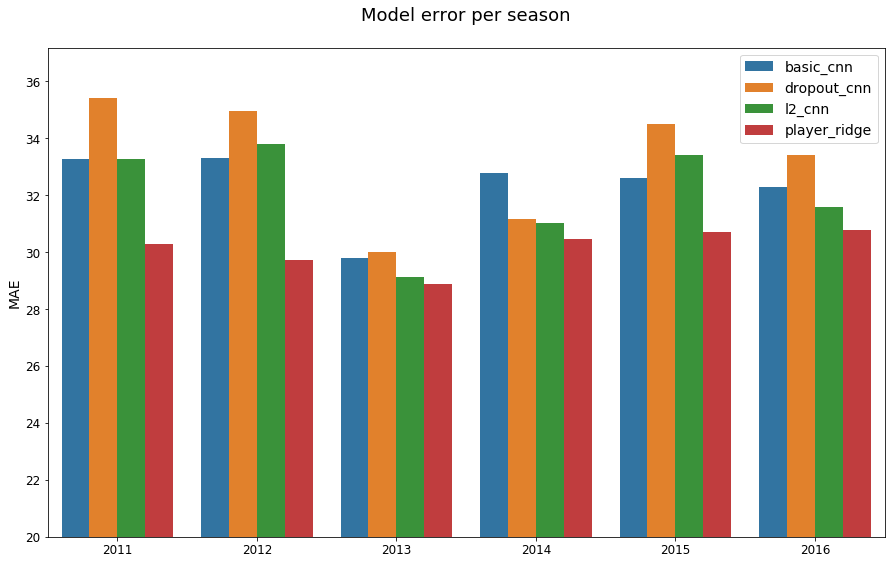

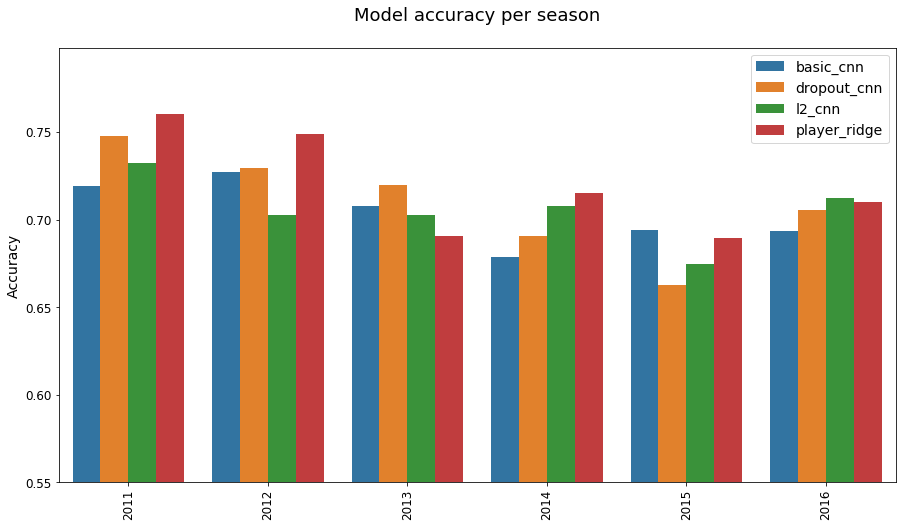

,accuracy,error,model,year
0,0.719388,33.270092,basic_cnn,2011
1,0.747449,35.415282,dropout_cnn,2011
2,0.732143,33.261856,l2_cnn,2011
3,0.727053,33.313928,basic_cnn,2012
4,0.729469,34.961634,dropout_cnn,2012
5,0.702899,33.802887,l2_cnn,2012
6,0.707729,29.785748,basic_cnn,2013
7,0.719807,29.991441,dropout_cnn,2013
8,0.702899,29.111341,l2_cnn,2013
9,0.678744,32.786894,basic_cnn,2014


In [10]:
estimators = [('basic_cnn', cnn_pipe), ('dropout_cnn', do_pipe), ('l2_cnn', l2_pipe)]
est_year_scores = pd.concat([yearly_performance_scores(estimators, features, labels),
                         yearly_ridge_performance_scores([('player_ridge', ridge_estimator)], ridge_X, ridge_y)],
                        sort=True)

graph_yearly_model_performance(est_year_scores)

est_year_scores

### Ridge with aggregation still has the best performance

The basic & l2 regularized CNNs are comparable, but Ridge performs better on both MAE & accuracy for most years.

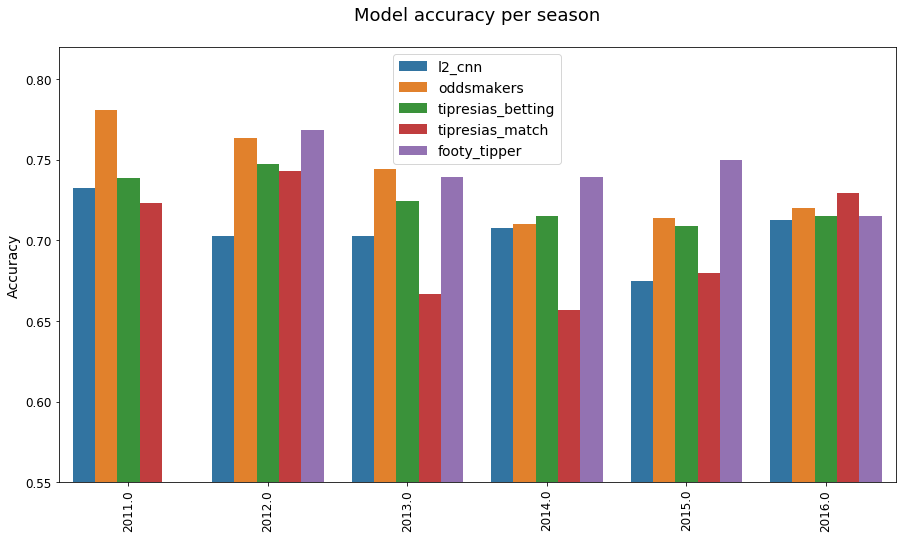

In [13]:
prediction_df = pd.read_csv('../data/model_predictions.csv')
prediction_scores = (prediction_df[prediction_df['model'] != 'tipresias_player']
                     .groupby(['model', 'year'])
                     .mean()['tip_point']
                     .reset_index()
                     .rename(columns={'tip_point': 'accuracy'}))
# Footy tipper accuracy scores taken from a trial that took too long to run,
# so I'm just copy pasting from a notebook
footy_tipper_scores = pd.DataFrame({'model': ['footy_tipper'] * len(range(2012, 2017)),
                                    'year': list(range(2012, 2017)),
                                    'error': [0] * len(range(2012, 2017)),
                                    'accuracy': [0.768116, 0.739130, 0.739130, 0.750000, 0.714976]})

all_year_scores = (pd
                   .concat([est_year_scores[est_year_scores['model'] == 'l2_cnn'],
                            prediction_scores,
                            footy_tipper_scores], sort=True)
                   .reset_index(drop=True))

graph_yearly_model_performance(all_year_scores[all_year_scores['year'] > 2010], error=False)

## Basic RNN

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 38s 3ms/step - loss: 34.4528 - tip_accuracy: 0.6024 - val_loss: 33.0860 - val_tip_accuracy: 0.6395
Epoch 2/20
13158/13158 [==============================] - 34s 3ms/step - loss: 32.4102 - tip_accuracy: 0.6631 - val_loss: 31.9313 - val_tip_accuracy: 0.6736
Epoch 3/20
13158/13158 [==============================] - 33s 3ms/step - loss: 31.5304 - tip_accuracy: 0.6781 - val_loss: 32.5089 - val_tip_accuracy: 0.6413
Epoch 4/20
13158/13158 [==============================] - 34s 3ms/step - loss: 30.8237 - tip_accuracy: 0.6895 - val_loss: 32.2335 - val_tip_accuracy: 0.6541
Epoch 5/20
13158/13158 [==============================] - 32s 2ms/step - loss: 30.2056 - tip_accuracy: 0.6997 - val_loss: 32.3424 - val_tip_accuracy: 0.6295
Epoch 6/20
13158/13158 [==============================] - 34s 3ms/step - loss: 29.8771 - tip_accuracy: 0.7073 - val_loss: 31.8057 - val_tip_accuracy: 0.6483
Epoch 7/2

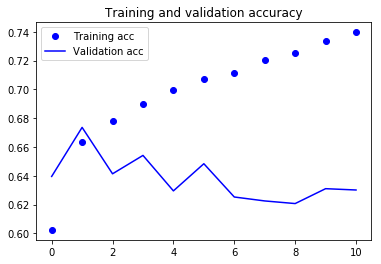

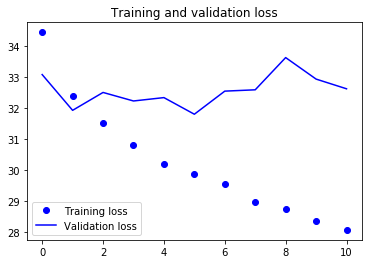

In [12]:
rnn_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='team')
rnn_oppo_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='oppo_team')
rnn_player_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='player')
rnn_stats_input = layers.Input(shape=(n_players_per_team_match, n_features - 3), dtype='float32', name='stats')

rnn_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(rnn_team_input)
rnn_oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(rnn_oppo_team_input)
rnn_player_layer = layers.Embedding(max_player_id + max_min_diff + 1, 4, input_length=n_players_per_team_match)(rnn_player_input)

rnn_concated_layers = layers.concatenate([rnn_team_layer, rnn_oppo_team_layer, rnn_player_layer, rnn_stats_input])

lstm_1 = layers.LSTM(50, dropout=0.2, return_sequences=True)(rnn_concated_layers)
lstm_2 = layers.LSTM(50, dropout=0.2, return_sequences=True)(lstm_1)
lstm_3 = layers.LSTM(50, dropout=0.2)(lstm_2)
rnn_output = layers.Dense(1, activation='linear')(lstm_3)

rnn_model = models.Model(
    inputs=[
        rnn_team_input,
        rnn_oppo_team_input,
        rnn_player_input,
        rnn_stats_input
    ],
    outputs=rnn_output
)

rnn_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])

rnn_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    DimensionReshaper((-1, n_players_per_team_match, n_features)),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=lambda: rnn_model,
                   epochs=20,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)])
)

rnn_pipe.fit(X_train, y_train)

graph_model_history(rnn_pipe.steps[-1][1].model.history)

### RNN is comparable to CNN but slower to train